In [1]:
import torch
from torch import nn, optim, tensor
from torch.utils.data import DataLoader, Dataset
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vectors
import pandas as pd
import time
import numpy as np
import torch.nn.functional as TF
import matplotlib.pyplot as plt
import copy
import json
import random
import pickle

## Load English & Chinese pretrained embedding from Tecent AI Lab

In [2]:
# Load pretrained model from Tencent
from gensim.models import KeyedVectors
# 100-dim en file
wv_from_text_en = KeyedVectors.load_word2vec_format("tencent-ailab-embedding-en-d100-v0.1.0-s", binary=False)

# 100-dim zh file
wv_from_text_zh = KeyedVectors.load_word2vec_format("tencent-ailab-embedding-zh-d100-v0.2.0-s.txt", binary=False)

In [3]:
# Define Chinese inputs for the model

# vocab_zh contains all the Chinese words in the dataset
vocab_zh      = wv_from_text_zh.index_to_key
vocab_size_zh = len(vocab_zh)
print("The first 10 words in the vocabulary are:", vocab_zh[:10])

# word_to_index_zh is the map between Chinese words and its indeces {'的'：3}
word_to_index_zh = wv_from_text_zh.key_to_index
print("The index for the Chinese word '的' is:", word_to_index_zh['的'])

The first 10 words in the vocabulary are: ['</s>', '，', ',', '的', '。', '、', '了', '：', '“', '”']
The index for the Chinese word '的' is: 3


In [122]:
# Define English inputs for the model

# vocab_en contains all the English words in the dataset
vocab_en      = wv_from_text_en.index_to_key
vocab_size_en = len(vocab_en)
print("The first 10 words in the vocabulary are:", vocab_en[:10])

# word_to_index_en is the map between English words and its indeces {'yes'：3}
word_to_index_en = wv_from_text_en.key_to_index
print("The index for the English word 'cannot' is:", word_to_index_en["cannot"])

The first 10 words in the vocabulary are: ['%2c', '.', '%22', 'and', 'of', '%3a', 'a', 'in', '/', '%29']
The index for the English word 'cannot' is: 1202


## Load Golden Set

In [5]:
# Load the golden set
with open("full_golden_set.json", encoding="utf-8-sig") as in_file:
  # returns JSON object as a dictionary
    golden_set = json.load(in_file)

# Closing file
in_file.close()

word = "universal"
print("Chinese translation for {} is {}".format(word, golden_set[word][0]))

en_vocab = golden_set.keys()

Chinese translation for universal is 普遍


In [62]:
# en_vocab_list is list of unique English words in golden set
gold_en_list = list(golden_set.keys())

# length of English vocabulary
gold_en_size = len(gold_en_list) 
print("There are", gold_en_size, "unique English words in our golden set")

There are 8063 unique English words in our golden set


## Data Preprocessing

In [7]:
torch.manual_seed(4)
np.random.seed(4)
random.seed(4)

In [76]:
# Define the training & testing data to pass for the custom dataset
# train_data is in the form of a dictionary that contains
# corresponding pair of English word (data) and Chinese 
# translation (label)
# Last 15% of the dataset is testing data

train_data = {}
test_data  = {}
en_list_train = []
zh_list_train = []
en_list_test = []
zh_list_test = []
en_list = []
zh_list = []
en_index_train = []
zh_index_train = []
en_index_test = []
zh_index_test = []

# Shuffle the data before splitting it into train & test samples
random.shuffle(gold_en_list)

# Make copies of english words that have more than 1 Chinese translation
for en in gold_en_list:
    for zh in golden_set[en]:
      en_list.append(en)
      zh_list.append(zh)

# Last 15% of data is allocated as testing samples
cutoff = int(len(en_list) * 0.75)
en_list_train = en_list[:cutoff]
zh_list_train = zh_list[:cutoff]
en_list_test  = en_list[cutoff:]
zh_list_test  = zh_list[cutoff:]
print("There are", len(en_list_train), "training data and", len(en_list_test), "testing data")

# The real training data are the words that exist in the Tecent AI dataset
en_index_train = [(i, word_to_index_en[i]) for i, j in zip(en_list_train, zh_list_train) if i in word_to_index_en and j in word_to_index_zh]
zh_index_train = [(i, word_to_index_zh[i]) for i, j in zip(zh_list_train, en_list_train) if i in word_to_index_zh and j in word_to_index_en]
en_index_test = [(i, word_to_index_en[i]) for i, j in zip(en_list_test, zh_list_test) if i in word_to_index_en and j in word_to_index_zh]
zh_index_test = [(i, word_to_index_zh[i]) for i, j in zip(zh_list_test, en_list_test) if i in word_to_index_zh and j in word_to_index_en]

train_data["data"]  = en_index_train
train_data["label"] = zh_index_train
test_data["data"]   = en_index_test
test_data["label"]  = zh_index_test

There are 6374 training data and 2125 testing data


In [115]:
if "grassland" in en_list_train: 
    print("galileo is in training data")
if "grassland" in en_list_test : 
    print("earthquake is in testing data")

earthquake is in testing data


In [9]:
print("There are {} training data present in the Tencent AI dataset".format(len(train_data["data"])))
print("There are {} testing data present in the Tencent AI dataset".format(len(test_data["data"])))

There are 6188 training data present in the Tencent AI dataset
There are 2048 testing data present in the Tencent AI dataset


In [10]:
print("The number of training data and label is the same", len(train_data["data"]) == len(train_data["label"]))
print("The number of testing data and label is the same", len(test_data["data"]) == len(test_data["label"]))

The number of training data and label is the same True
The number of testing data and label is the same True


In [11]:
train_data["data"][10], train_data["label"][10]

(('analytic', 44911), ('解析', 4224))

## Custom Dataset

In [12]:
# Define dataset to load to dataloader
class TrainData(Dataset):
    
    def __init__(self, data):
        """Loads the data from the pretrained model"""
        self.data    = data
        self.en_list = self.data["data"]
        self.zh_list = self.data["label"]
      
    def __getitem__(self, idx):
        """Returns the datapoint at a given index"""
        en_index = self.en_list[idx][1]
        zh_index = self.zh_list[idx][1]
        sample = {"en_index": en_index, "zh_index": zh_index}
        return sample
    
    def __len__(self):
        """Returns the number of datapoints in the dataset"""
        return len(self.data["data"])

In [13]:
def collate_batch(batch):
    """Converts a batch of data into packed PyTorch tensor format
    """
    # Initialize lists that separate out the 3 components
    en_index_list  = list()
    zh_index_list  = list()
    
    for pair in batch:
        en_index = pair["en_index"]
        zh_index = pair["zh_index"]
        # Convert to PyTorch format
        # Add converted data to separate component lists
        en_index_list.append(en_index)
        zh_index_list.append(zh_index)
    
    # Convert to mini-batch tensors
    en_index_tensor = torch.tensor(en_index_list).to(torch.int64)
    zh_index_tensor = torch.tensor(zh_index_list).to(torch.int64)
    
    return (en_index_tensor, zh_index_tensor)

In [97]:
batch_size = 256
training_data = TrainData(train_data)
testing_data  = TrainData(test_data)
train_dataloader = DataLoader(dataset=training_data, 
                              batch_size=batch_size, 
                              shuffle=True,  
                              collate_fn=collate_batch)
test_dataloader  = DataLoader(dataset=testing_data, 
                              batch_size=batch_size, 
                              shuffle=True,  
                              collate_fn=collate_batch)

In [15]:
next(iter(train_dataloader))

vocab_en[123683], vocab_zh[44977]

('gorges', '三峡')

In [16]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

## Learning rate schedulor

Text(0.5, 1.0, 'Cosine Scheduler')

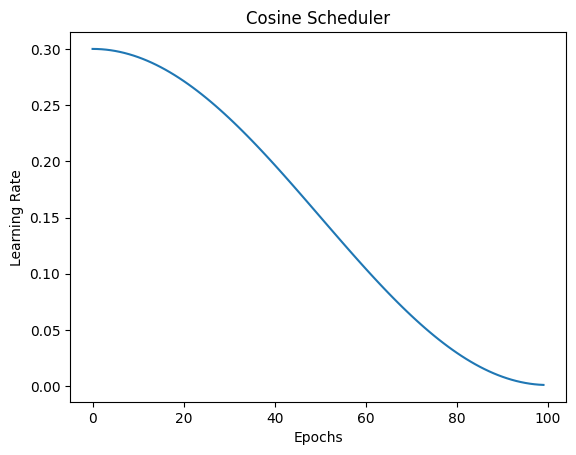

In [17]:
# credit: https://d2l.ai/chapter_optimization/lr-scheduler.html
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=100, base_lr=0.3, final_lr=0.001)
num_epochs = 100
sch = [scheduler(t) for t in range(num_epochs)]
xtrain = np.arange(num_epochs)
plt.plot(xtrain, sch)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Cosine Scheduler")


## Model Definitions

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [19]:
class ZhZhAutoencoderTW(nn.Module):
    """
    Autoencoder to learn the weights connecting Chinese 
    embeddings back to one-hot vectors. Initialize the 
    weights connecting the embeddings and one-hot vectors 
    with the transpose of the weights from the Tecent 
    pretrained model, connecting the one-hot vector and
    embedding, to speed up training.
    """
    def __init__(self, pretrained, vocab):
        super(ZhZhAutoencoderTW, self).__init__()
        
        # Save the pretrained embedding within the model
        # load pretrained embeddings and freeze them
        self.weights    = torch.FloatTensor(pretrained.vectors) 
        self.encoder    = nn.Embedding.from_pretrained(self.weights, freeze = True)
        
        # Make a copy of the pretrained weights and use them in the following layers
        copy_pretrained = copy.deepcopy(pretrained)
        self.copyweight = torch.FloatTensor(copy_pretrained.vectors) 
        self.decoder    = nn.Parameter(self.copyweight.t()) 
        self.vocab      = vocab

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the embeddings for text
        trained_embed = self.encoder(text)
        
        # Turn embedding back to one-hot
        one_hot       = trained_embed @ self.decoder 
        
        return one_hot

In [20]:
# Autoencoder to learn the weights connecting embeddings back to one-hot vectors
class EnZhAutoencoderHidden(nn.Module):
    
    def __init__(self, pretrained_en, pretrained_zh):
        super(EnZhAutoencoderHidden, self).__init__()
        
        # Save the pretrained English embedding from Tencent within the model
        # load pretrained embeddings and freeze them
        self.weights_en = torch.FloatTensor(pretrained_en.vectors) 
        self.encoder    = nn.Embedding.from_pretrained(self.weights_en, freeze = True)
        
        # Load the pretrained weights from zhzhautoencoder 
        # Use the pretrained weights to map Chinese embedding to one-hot
        # ***** use the tranpose!!!
        self.zh_weights = pretrained_zh
        self.decoder    = nn.Parameter(self.zh_weights, requires_grad=False)

        # Hidden layer definition
        self.hidden = nn.Sequential(
            nn.Linear(100, 75), 
            nn.LeakyReLU(),
            nn.Linear(75, 100)
        )

    def forward(self, text):
        """The pipeline that takes input values through the network"""
        # Find the English embedding
        eng_emb = self.encoder(text)
        
        # Pass the English embedding through hidden layer
        zh_emb  = self.hidden(eng_emb) # torch.Size([256, 100])

        # Find the corresponding index of Chinese word for 
        # the English embedding decoder: torch.Size([100, 2000000])
        one_hot = zh_emb @ self.decoder

        return one_hot

In [21]:
def train(model, file, modelFilePath, num_epochs, optimizer, criterion):
    # Training
    avg_loss = []
    accuracy_test = []
    losses = 0
    start = time.time()
    print("Start Batch Size =", batch_size, file=open(file, 'a'))
    scheduler = CosineScheduler(max_update=num_epochs, base_lr=0.3, final_lr=0.001)
    for epoch in range(num_epochs):
        losses = 0
        for i, (en_index, zh_index) in enumerate(train_dataloader):
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Move inputs & outputs to cuda
            en_index = en_index.to(device) 
            zh_index = zh_index.to(device) 
            
            # Forward pass to get output/logits
            outputs_train = model(en_index)
        
            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs_train, zh_index)
            losses += loss.item()
        
            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

        avg = losses / len(train_dataloader.dataset)
        avg_loss.append(avg)
        
        # Test the model every 5 epochs
        if epoch % 5 == 0:
            accuracy = test(model, file)
            accuracy_test.append(accuracy)
            model.train() 

        for param_group in optimizer.param_groups:
            param_group['lr'] = scheduler(epoch)
            print("Learning rate is now", param_group['lr'], file=open(file, 'a'))
    
        print('%s (%d %d%%) %.15f' % (timeSince(start), epoch, epoch / num_epochs * 100, avg), file=open(file, 'a'))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg,
            }, modelFilePath)
            
    print("Finish training!", file=open(file, 'a'))
    return avg_loss, accuracy_test

def test(model, file):
    correct_test = 0
    total_test = 0
    
    model.eval()
    with torch.no_grad():
        # Iterate through test dataset
        for i, (en_index, zh_index) in enumerate(test_dataloader):
        
            # Move inputs & outputs to cuda
            en_index = en_index.to(device) 
            zh_index = zh_index.to(device) 

            # Forward pass only to get logits/output
            outputs_test = model(en_index)

            # Get predictions from the maximum value
            # check dimension of softmax
            prob  = TF.softmax(outputs_test, dim=1)
            index = torch.argmax(prob, dim=1)
            
            # Total number of labels
            total_test += en_index.size(0)
            
            # Total correct predictions
            correct_test += (index == zh_index).sum()
            
        accuracy = 100 * correct_test.item() / total_test
        
        # Print Loss
        print('Accuracy: %.15f' % (accuracy), file=open(file, 'a'))
           
        return accuracy

In [22]:
model_zhzh = ZhZhAutoencoderTW(wv_from_text_zh, vocab_zh).to(device)
model_zhzh_weight = torch.load('/mldata/jingyi_wu/ling111_project_wt.pt')
model_zhzh.load_state_dict(model_zhzh_weight)

<All keys matched successfully>

In [ ]:
# Extract the decoder weights to use in the final autoencoder
print("The weights in the ZhZhAutoencoderTW model are", model_zhzh.state_dict().keys())

In [23]:
model_enzh_decoder = model_zhzh.decoder.clone()
model_enzh = EnZhAutoencoderHidden(wv_from_text_en, model_enzh_decoder).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_enzh.parameters(), lr=0.3)

In [25]:
loss, acc = train(model_enzh, 'enzh_hidden75.txt', '/mldata/jingyi_wu/enzh_hidden75.ckpt', 101, optimizer, criterion)

In [26]:
# save the losses in the pickle file
import pickle  
with open('avg_loss_enzh75.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(loss, file)

In [27]:
# load the losses to the pickle file
with open('avg_loss_enzh75.pkl', 'rb') as file:
      
    # Call load method to deserialze
    avg_loss_enzh75 = pickle.load(file)
 

In [28]:
import pickle  
with open('acc_enzhsacc75.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(acc, file)

In [123]:
# load the losses to the pickle file
with open('acc_enzhsacc75.pkl', 'rb') as file:
      
    # Call load method to deserialze
    acc = pickle.load(file)

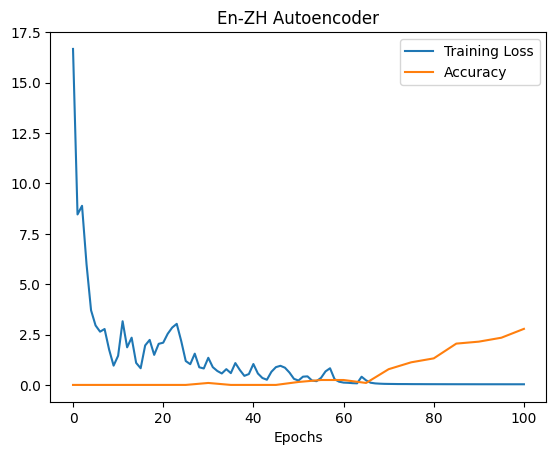

In [33]:
xtrain = np.arange(101)
xacc = np.arange(0, 101, 5)
plt.plot(xtrain, avg_loss_enzh75, label = "Training Loss")
plt.plot(xacc, acc, label = "Accuracy")
plt.xlabel("Epochs")
plt.title("En-ZH Autoencoder")
plt.legend()

## Let's test some examples

In [34]:
# Load checkpoint
checkpoint = torch.load('/mldata/jingyi_wu/enzh_hidden75.ckpt')
model_enzh.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [124]:
# Get some samples from test data
test_dataloader  = DataLoader(dataset=testing_data, 
                              batch_size=10, 
                              shuffle=True,  
                              collate_fn=collate_batch)
example = next(iter(test_dataloader))

In [125]:
# Get model predictions for the samples
exOutput = model_enzh(example[0].to(device))

In [126]:
# Get index from model predictions
prob_ex = TF.softmax(exOutput, dim=1)
index_ex = torch.argmax(prob_ex, dim=1)

In [127]:
# Get corresponding English and Chinese words from the indeces
for i, j in zip(example[0].tolist(), index_ex.tolist()):
    print("{} & {} \n".format(vocab_en[i], vocab_zh[j]))

metropolis & 鹿泉市 

lake & 国模沟沟 

chauvinism & 民族主义 

peoples & 祖先 

pharynx & 导管 

streetlight & 路灯 

scald & 初三日记大全 

hemp & 硫磺 

holland & 07-08 

convalesce & 住进医院 

